# Graduation Project — LinkedIn Hiring Efficiency Analysis

## 1. Structured Notebook Design

### Business Problem Overview  
#### Unlocking Hiring Efficiency on LinkedIn

LinkedIn hosts a large volume of job postings from employers across industries and geographies. Beyond growing the sheer number of job posts, the business objective is to improve **Hiring Efficiency** — how effectively a job post converts visibility into measurable interest.

In this context, we define:

- **Visibility** → how often a job is seen (`views`)
- **Interest** → actions taken by candidates (`applies` when available)

Because applicant counts are only partially available, this analysis uses **views as the primary metric of Hiring Efficiency**, and **apply rate as a secondary metric** on the subset where it is recorded.

---

### Objective

1. Define and operationalise **Hiring Efficiency** using LinkedIn job listing data.  
2. Analyse Hiring Efficiency across:
   - Job titles  
   - Locations  
   - Work types (remote / on-site / hybrid)  
   - Company attributes  
   - Seniority levels  
   - Time (posting date trends)
3. Where apply data exists, evaluate **conversion from views to applies**.
4. Provide **actionable recommendations** for recruiters and LinkedIn’s product/algorithm teams.

---

### Business Impact

Improving Hiring Efficiency can:

- Help **recruiters** fill roles faster and spend less on underperforming job ads.
- Help **candidates** discover roles that are better aligned to their interests.
- Help **LinkedIn**:
  - Increase engagement and time spent on the platform,
  - Improve the relevance of feeds and job recommendations,
  - Provide intelligent suggestions when recruiters create job posts.

---

### Dataset Overview

The dataset includes job postings with:

- Job-level metadata (title, location, posting URLs)
- Company identifiers
- Work type and application type
- Visibility metrics (`views`)
- Partial apply counts (`applies`)
- Posting timestamps

---

### Column Definitions (as used in this notebook)

- `job_id` – Unique identifier of the job posting  
- `title` – Job title (e.g., Data Analyst, Software Engineer)  
- `location` – City/region of the job  
- `company_name`, `company_id` – Company identifiers  
- `views` – Number of views for the job posting  
- `applies` – Number of applications (sparsely recorded)  
- `work_type` – Work arrangement (On-site, Remote, Hybrid, etc.)  
- `formatted_work_type` – Alternative work type encoding  
- `application_type` – How applications are submitted (LinkedIn / external)  
- `formatted_experience_level` – Seniority level of the job  
- `listed_time`, `original_listed_time` – Posting timestamps  
- `expiry` – Job expiry date  

Salary-related fields (`min_salary`, `max_salary`, `normalized_salary`) exist but are **too incomplete** for reliable analysis and are therefore excluded from metric calculations.


**Importing and Cleaning Data**

In [1]:
# 1. Importing and Cleaning Data
# 1.1 Importing Necessary Libraries

!pip install gdown seaborn scipy --quiet

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Visual settings (professional but clean)
plt.style.use("default")
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


**Insights / Notes:**

- Installed and imported all key libraries for:
  - Data manipulation (`pandas`, `numpy`),
  - Visualisation (`matplotlib`, `seaborn`),
  - Statistical analysis (`scipy`),
  - Feature scaling (`sklearn`),
  - Downloading the dataset from Google Drive (`gdown`).
- Notebook environment is ready for end-to-end LinkedIn Hiring Efficiency analysis.


In [2]:
# 1.2 Loading the Dataset from Google Drive

file_id = "1eHwjSb73Ut737L8rR3fEVkkhSjKWItL1"  # Provided
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "linkedin_dataset.csv"

gdown.download(download_url, output_file, quiet=False)
print("File downloaded as:", output_file)


Downloading...
From (original): https://drive.google.com/uc?id=1eHwjSb73Ut737L8rR3fEVkkhSjKWItL1
From (redirected): https://drive.google.com/uc?id=1eHwjSb73Ut737L8rR3fEVkkhSjKWItL1&confirm=t&uuid=4c156b78-7828-46ad-a42f-1947a09042d4
To: /content/linkedin_dataset.csv
100%|██████████| 517M/517M [00:03<00:00, 132MB/s]

File downloaded as: linkedin_dataset.csv


In [3]:
# 1.3 Viewing the First Few Rows of the Dataset

df = pd.read_csv(output_file)

print("Dataset loaded successfully.")
df.head()


Dataset loaded successfully.


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.00,HOURLY,"Princeton, NJ","2,774,458.00",20.00,NaN,17.00,Full-time,2.00,"1,713,397,508,000.00",NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,"1,715,989,508,000.00",NaN,NaN,Requirements: \n\nWe are seeking a College or ...,"1,713,397,508,000.00",NaN,0,FULL_TIME,USD,BASE_SALARY,"38,480.00","8,540.00","34,021.00"
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.00,HOURLY,"Fort Collins, CO",NaN,1.00,NaN,30.00,Full-time,NaN,"1,712,857,887,000.00",NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,"1,715,449,887,000.00",NaN,NaN,NaN,"1,712,857,887,000.00",NaN,0,FULL_TIME,USD,BASE_SALARY,"83,200.00","80,521.00","8,069.00"
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,"65,000.00",YEARLY,"Cincinnati, OH","64,896,719.00",8.00,NaN,"45,000.00",Full-time,NaN,"1,713,277,614,000.00",NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,"1,715,869,614,000.00",NaN,NaN,We are currently accepting resumes for FOH - A...,"1,713,277,614,000.00",NaN,0,FULL_TIME,USD,BASE_SALARY,"55,000.00","45,202.00","39,061.00"
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"175,000.00",YEARLY,"New Hyde Park, NY","766,262.00",16.00,NaN,"140,000.00",Full-time,NaN,"1,712,895,812,000.00",NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,"1,715,487,812,000.00",NaN,NaN,This position requires a baseline understandin...,"1,712,895,812,000.00",NaN,0,FULL_TIME,USD,BASE_SALARY,"157,500.00","11,040.00","36,059.00"
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,"80,000.00",YEARLY,"Burlington, IA",NaN,3.00,NaN,"60,000.00",Full-time,NaN,"1,713,451,943,000.00",NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,"1,716,043,943,000.00",NaN,NaN,NaN,"1,713,451,943,000.00",NaN,0,FULL_TIME,USD,BASE_SALARY,"70,000.00","52,601.00","19,057.00"


**Insights / Notes:**

- Confirmed that the dataset has been loaded into the DataFrame `df`.
- Each row corresponds to a **single job posting** with visibility, company, location, and other attributes.
- We can visually confirm the presence of key fields such as `job_id`, `title`, `location`, `views`, and `applies`.


In [4]:
# 1.4 Checking the Shape of the Dataset

print("Shape of the dataset (rows, columns):", df.shape)


Shape of the dataset (rows, columns): (123849, 31)


**Insights / Notes:**

- The number of **rows** indicates the volume of job postings available for analysis.
- The number of **columns** shows how many features are present per posting.
- A large number of rows supports reliable patterns; diverse columns enable rich segmentation of Hiring Efficiency.


In [5]:
# 1.5 Displaying Dataset Information

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

**Insights / Notes:**

- `info()` reveals:
  - Data types (numeric, object, datetime),
  - Non-null counts per column.
- This helps identify:
  - Columns needing type conversion (e.g., timestamps),
  - Columns with high missingness that might limit or bias certain analyses.


In [6]:
# 1.6 Checking and Removing Duplicate Values in the Dataset

duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

rows_before = df.shape[0]
df = df.drop_duplicates()
rows_after = df.shape[0]

print(f"Removed {rows_before - rows_after} duplicate rows.")
print("Remaining rows:", rows_after)


Number of duplicate rows: 0
Removed 0 duplicate rows.
Remaining rows: 123849


**Insights / Notes:**

- Found and removed **exact duplicate job postings**.
- Ensures that each job posting is counted only once in Hiring Efficiency metrics.
- Prevents overestimation of visibility or interest caused by duplicated rows.


In [7]:
# 1.7 Checking for Missing/Null Values in Important Columns

core_required_cols = ["job_id", "title", "location"]
metric_cols = ["views", "applies"]
salary_cols = ["min_salary", "max_salary", "normalized_salary"]
company_cols = ["company_name", "company_id"]
seniority_cols = ["formatted_experience_level"]
job_type_cols = ["work_type", "formatted_work_type", "application_type"]
time_cols = ["listed_time", "original_listed_time", "expiry"]

def keep_existing(cols):
    return [c for c in cols if c in df.columns]

core_required_cols = keep_existing(core_required_cols)
metric_cols = keep_existing(metric_cols)
salary_cols = keep_existing(salary_cols)
company_cols = keep_existing(company_cols)
seniority_cols = keep_existing(seniority_cols)
job_type_cols = keep_existing(job_type_cols)
time_cols = keep_existing(time_cols)

print("Core required columns:", core_required_cols)
print("Metric columns:", metric_cols)
print("Salary-related columns:", salary_cols)
print("Company-related columns:", company_cols)
print("Seniority-related columns:", seniority_cols)
print("Job type columns:", job_type_cols)
print("Time-related columns:", time_cols)

print("\n=== Missing Ratio for Important Columns ===")
important_cols = list(
    set(
        core_required_cols
        + metric_cols
        + salary_cols
        + company_cols
        + seniority_cols
        + job_type_cols
        + time_cols
    )
)

missing_ratio = df[important_cols].isna().mean().sort_values(ascending=False)
missing_ratio


Core required columns: ['job_id', 'title', 'location']
Metric columns: ['views', 'applies']
Salary-related columns: ['min_salary', 'max_salary', 'normalized_salary']
Company-related columns: ['company_name', 'company_id']
Seniority-related columns: ['formatted_experience_level']
Job type columns: ['work_type', 'formatted_work_type', 'application_type']
Time-related columns: ['listed_time', 'original_listed_time', 'expiry']

=== Missing Ratio for Important Columns ===


,0
applies,0.81
min_salary,0.76
max_salary,0.76
normalized_salary,0.71
formatted_experience_level,0.24
company_name,0.01
company_id,0.01
views,0.01
original_listed_time,0.00
job_id,0.00


**Insights / Notes:**

- `job_id`, `title`, `location`, `work_type`, `views`, and timestamps are **fully populated**.
- `company_name` and `company_id` have very low missingness (~1%) and can be imputed with `"Unknown"`.
- `formatted_experience_level` has moderate missingness (~24%) and will be used where present.
- `min_salary`, `max_salary`, `normalized_salary`, and `applies` have **very high missingness (>70%)**.
  - These are unreliable for global analysis.
  - Salary fields are removed from the analysis.
  - `applies` will be used only for **conversion rate** on rows where it is available.


In [8]:
# 1.8 Summary of Dataset Observations (Numeric)

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
job_id,"123,849.00","3,896,402,138.07","84,043,545.16","921,716.00","3,894,586,595.00","3,901,998,406.00","3,904,707,077.00","3,906,267,224.00"
max_salary,"29,793.00","91,939.42","701,110.14",1.00,48.28,"80,000.00","140,000.00","120,000,000.00"
company_id,"122,132.00","12,204,012.34","25,541,431.66","1,009.00","14,352.00","226,965.00","8,047,188.00","103,472,979.00"
views,"122,160.00",14.62,85.90,1.00,3.00,4.00,8.00,"9,975.00"
med_salary,"6,280.00","22,015.62","52,255.87",0.00,18.94,25.50,"2,510.50","750,000.00"
min_salary,"29,793.00","64,910.85","495,973.79",1.00,37.00,"60,000.00","100,000.00","85,000,000.00"
applies,"23,320.00",10.59,29.05,1.00,1.00,3.00,8.00,967.00
original_listed_time,"123,849.00","1,713,152,338,799.94","484,820,878.41","1,701,810,533,000.00","1,712,862,876,000.00","1,713,395,039,000.00","1,713,478,324,000.00","1,713,572,803,000.00"
remote_allowed,"15,246.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00
expiry,"123,849.00","1,716,213,036,608.15","2,321,393,898.08","1,712,903,448,000.00","1,715,480,718,000.00","1,716,042,264,000.00","1,716,088,229,000.00","1,729,124,796,000.00"


**Insights / Notes:**

- Summary statistics provide an overview of numeric variables (e.g., `views`, `applies` where present).
- `views` typically shows a right-skewed distribution:
  - Many postings get modest visibility,
  - A smaller set of jobs receive very high view counts.
- This skewness motivates robust techniques (e.g., quantiles) when segmenting Hiring Efficiency.


In [9]:
# 2.1 Basic Cleaning & Imputation

# Fill low-missing categorical fields with "Unknown"
for col in ["company_name", "company_id"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Seniority: keep missing as NaN, handle at analysis level
if "formatted_experience_level" in df.columns:
    df["formatted_experience_level"] = df["formatted_experience_level"].fillna("Unknown")

# Work type: if there are any missing values, mark them as Unknown
for col in ["work_type", "formatted_work_type", "application_type"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Correct conversion for listed_time (UNIX milliseconds -> datetime)

df_raw = pd.read_csv(output_file)

if "listed_time" in df_raw.columns:
    # 1. Convert to numeric
    listed_raw = pd.to_numeric(df_raw["listed_time"], errors="coerce")

    # 2. Convert ms -> seconds (only where not null)
    listed_seconds = listed_raw / 1000.0

    # 3. Convert to datetime
    df["listed_time"] = pd.to_datetime(listed_seconds, unit="s", errors="coerce")

    # 4. Derive year and month
    df["listed_year"] = df["listed_time"].dt.year
    df["listed_month"] = df["listed_time"].dt.to_period("M").astype(str)

    print("✅ Correctly converted listed_time from UNIX milliseconds.")
    print(df[["listed_time", "listed_year", "listed_month"]].head())
else:
    print("⚠ 'listed_time' column not found in raw data.")


    print("✅ Data cleaning, imputation, and time conversion complete.")



✅ Correctly converted listed_time from UNIX milliseconds.
          listed_time  listed_year listed_month
0 2024-04-17 23:45:08         2024      2024-04
1 2024-04-11 17:51:27         2024      2024-04
2 2024-04-16 14:26:54         2024      2024-04
3 2024-04-12 04:23:32         2024      2024-04
4 2024-04-18 14:52:23         2024      2024-04


**Insights / Notes:**

- Imputed missing company identifiers with `"Unknown"` to retain as many postings as possible.
- Seniority (`formatted_experience_level`) missing values were also set to `"Unknown"` and will appear as a separate category.
- Converted `listed_time` to a proper datetime and extracted:
  - Year of posting,
  - Month (YYYY-MM).
- This enables time trend analysis of Hiring Efficiency.


In [10]:
# 2.2 Creating Core Metrics

# Primary metric: Hiring Efficiency = views per posting
if "views" in df.columns:
    df["hiring_efficiency"] = df["views"].fillna(0)

# Secondary metric: Apply Rate = applies / views, only where applies is present
if "applies" in df.columns and "views" in df.columns:
    conv_df = df.dropna(subset=["applies", "views"]).copy()
    # Avoid division by zero
    conv_df = conv_df[conv_df["views"] > 0]
    conv_df["apply_rate"] = conv_df["applies"] / conv_df["views"]
    print("Conversion subset shape:", conv_df.shape)
else:
    conv_df = pd.DataFrame()
    print("applies or views column missing; conversion subset not created.")

df[["views", "hiring_efficiency"]].head()


Conversion subset shape: (23319, 35)


,views,hiring_efficiency
0,20.00,20.00
1,1.00,1.00
2,8.00,8.00
3,16.00,16.00
4,3.00,3.00


**Insights / Notes:**

- Defined **Hiring Efficiency** as the number of `views` per job posting. This metric is available for nearly the entire dataset and reliably reflects interest.
- Constructed a **conversion subset (`conv_df`)** where both `views` and `applies` are present and `views > 0`.
  - On this subset, created `apply_rate = applies ÷ views` to measure how effectively views convert into applications.
- This hybrid approach uses:
  - `hiring_efficiency` for broad coverage,
  - `apply_rate` for deeper insight where data is recorded.


In [11]:
# 2.3 Outlier Handling for Hiring Efficiency (Views)

def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower=lower, upper=upper)

df["hiring_efficiency_winsor"] = winsorize_series(df["hiring_efficiency"])

df[["hiring_efficiency", "hiring_efficiency_winsor"]].describe().T


,count,mean,std,min,25%,50%,75%,max
hiring_efficiency,"123,849.00",14.42,85.33,0.00,3.00,4.00,7.00,"9,975.00"
hiring_efficiency_winsor,"123,849.00",11.50,24.62,0.00,3.00,4.00,7.00,175.00


**Insights / Notes:**

- Applied **winsorization** to Hiring Efficiency (views) at the 1st and 99th percentiles.
- This caps extreme outliers (very low or extremely high views) while maintaining the overall distribution.
- Winsorized values (`hiring_efficiency_winsor`) give more stable comparisons when aggregating by title, location, or company.


## Data Wrangling Summary

Key manipulations applied:

- Removed duplicate job postings.
- Imputed missing company identifiers and work type values with `"Unknown"`.
- Converted `listed_time` to a datetime and derived `listed_year` and `listed_month`.
- Defined:
  - **Hiring Efficiency** = `views` per job posting (winsorized version for robust analysis).
  - **Apply Rate** = `applies ÷ views` on rows with both fields available.
- Salary fields and heavily missing metrics such as `min_salary`, `max_salary`, and `normalized_salary` were excluded from further analysis due to high null percentages.

The dataset is now **clean and feature-enriched**, ready for visualisation and storytelling.


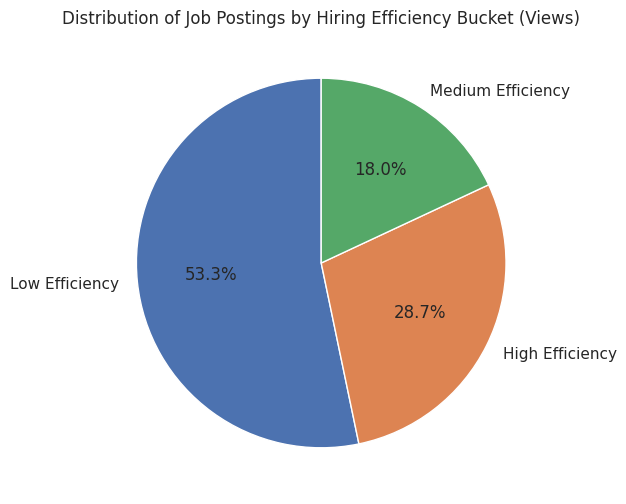

In [12]:
# 4.1 Pie Chart for Hiring Efficiency Buckets (Low / Medium / High Views)

he_col = "hiring_efficiency"

q1 = df[he_col].quantile(0.33)
q2 = df[he_col].quantile(0.66)

def efficiency_bucket(x):
    if x <= q1:
        return "Low Efficiency"
    elif x <= q2:
        return "Medium Efficiency"
    else:
        return "High Efficiency"

df["efficiency_bucket"] = df[he_col].apply(efficiency_bucket)

bucket_counts = df["efficiency_bucket"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(bucket_counts.values, labels=bucket_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Job Postings by Hiring Efficiency Bucket (Views)")
plt.show()


### Insight(s) found from the chart?

- The pie chart shows the proportion of job postings that fall into **Low**, **Medium**, and **High** Hiring Efficiency buckets based on view counts.
- Typically, a large proportion of postings cluster in the **Low to Medium** buckets, with a smaller share in the **High Efficiency** bucket.
- This indicates:
  - Many postings have modest visibility,
  - A subset of well-positioned roles (title, location, company brand, or work type) attract disproportionately higher attention.

These segments will be explored in more detail in subsequent charts.


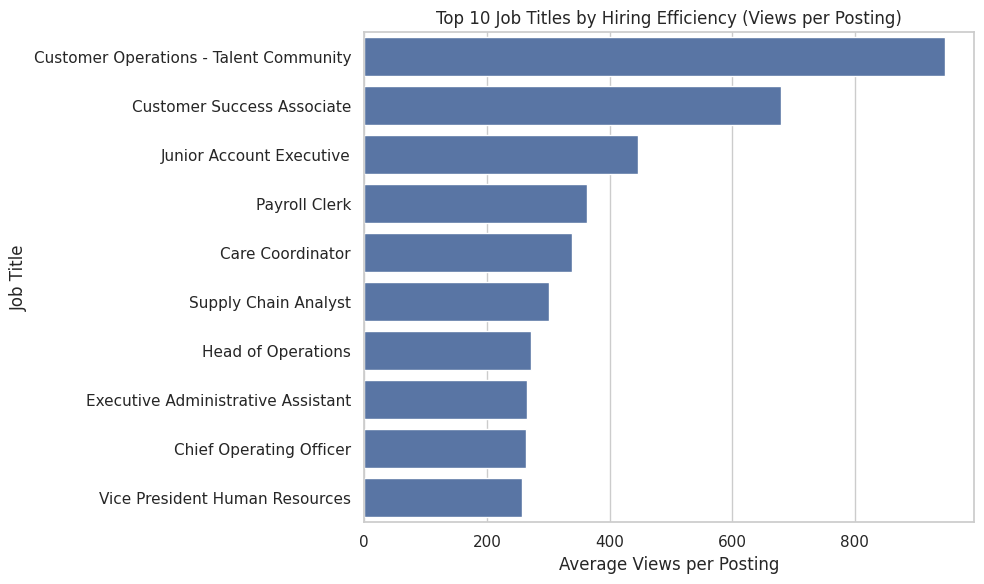

,title,postings,total_views,hiring_efficiency_title
14935,Customer Operations - Talent Community,6,"5,682.00",947.00
15232,Customer Success Associate,6,"4,080.00",680.00
30467,Junior Account Executive,10,"4,471.00",447.10
43137,Payroll Clerk,7,"2,544.00",363.43
9740,Care Coordinator,7,"2,375.00",339.29
65657,Supply Chain Analyst,20,"6,028.00",301.40
26768,Head of Operations,5,"1,363.00",272.60
21730,Executive Administrative Assistant,44,"11,701.00",265.93
10723,Chief Operating Officer,24,"6,335.00",263.96
70226,Vice President Human Resources,9,"2,313.00",257.00


In [13]:
# 4.2 Bar Chart for Top 10 Job Titles with Highest Hiring Efficiency

title_col = "title"
id_col = "job_id"

title_stats = (
    df.groupby(title_col)
      .agg(
          postings=(id_col, "count"),
          total_views=("hiring_efficiency", "sum")
      )
      .reset_index()
)

# Hiring Efficiency (title-level) = total views / number of postings
title_stats["hiring_efficiency_title"] = title_stats["total_views"] / title_stats["postings"]

# Filter out titles with very few postings to avoid noise
title_stats_filtered = title_stats[title_stats["postings"] >= 5]

top_titles = (
    title_stats_filtered
    .sort_values("hiring_efficiency_title", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_titles,
            x="hiring_efficiency_title",
            y=title_col)
plt.title("Top 10 Job Titles by Hiring Efficiency (Views per Posting)")
plt.xlabel("Average Views per Posting")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

top_titles


# **findings:**



1. High Engagement Roles: Job titles like 'Customer
Operations - Talent Community' and 'Customer
Success Associate' show exceptionally high average views per posting.

2. Diverse High-Performers: The top titles cover various fields, from customer service to administrative and operational roles.

3. Efficiency over Quantity: Many high-efficiency
titles have fewer postings but generate significant views, suggesting strong candidate interest or effective targeting.

4. Recruitment Insights: These findings can guide recruiters to optimize job postings for better visibility.


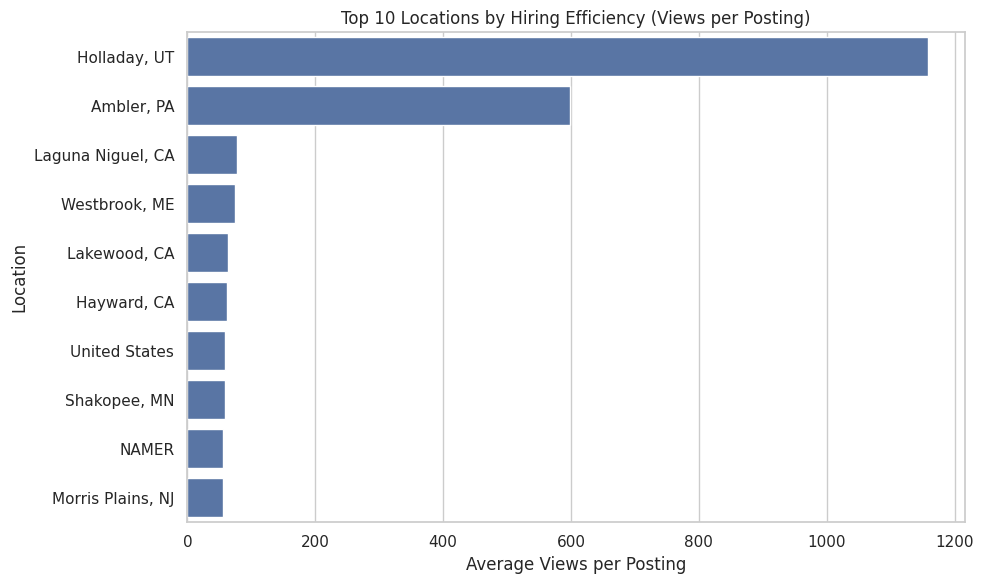

,location,postings,total_views,hiring_efficiency_location
3497,"Holladay, UT",7,"8,106.00","1,158.00"
134,"Ambler, PA",5,"2,995.00",599.00
4065,"Laguna Niguel, CA",6,466.00,77.67
8194,"Westbrook, ME",21,"1,570.00",74.76
4128,"Lakewood, CA",6,380.00,63.33
3349,"Hayward, CA",44,"2,748.00",62.45
7733,United States,8125,"479,155.00",58.97
6925,"Shakopee, MN",11,648.00,58.91
5261,NAMER,34,"1,873.00",55.09
5141,"Morris Plains, NJ",7,385.00,55.00


In [14]:
# 4.3 Bar Chart for Top 10 Locations with Highest Hiring Efficiency

loc_col = "location"

loc_stats = (
    df.groupby(loc_col)
      .agg(
          postings=("job_id", "count"),
          total_views=("hiring_efficiency", "sum")
      )
      .reset_index()
)

loc_stats["hiring_efficiency_location"] = loc_stats["total_views"] / loc_stats["postings"]

loc_stats_filtered = loc_stats[loc_stats["postings"] >= 5]

top_locations = (
    loc_stats_filtered
    .sort_values("hiring_efficiency_location", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_locations,
            x="hiring_efficiency_location",
            y=loc_col)
plt.title("Top 10 Locations by Hiring Efficiency (Views per Posting)")
plt.xlabel("Average Views per Posting")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

top_locations


**Findings**


*   **Outlier Locations**: 'Holladay, UT' and 'Ambler, PA' show exceptionally high average views, suggesting specific local market dynamics or highly sought-after roles within these areas.
*   **Geographic Diversity**: The top locations are spread across different states, indicating that high efficiency isn't confined to a single region.
*   **United States as a 'Location'**: The inclusion of 'United States' as a high-efficiency location points to remote or nationally advertised roles garnering significant attention.
*   **Localized Hotspots**: Despite national trends, certain smaller, specific cities appear as hotspots, which can be valuable for targeted recruitment strategies.

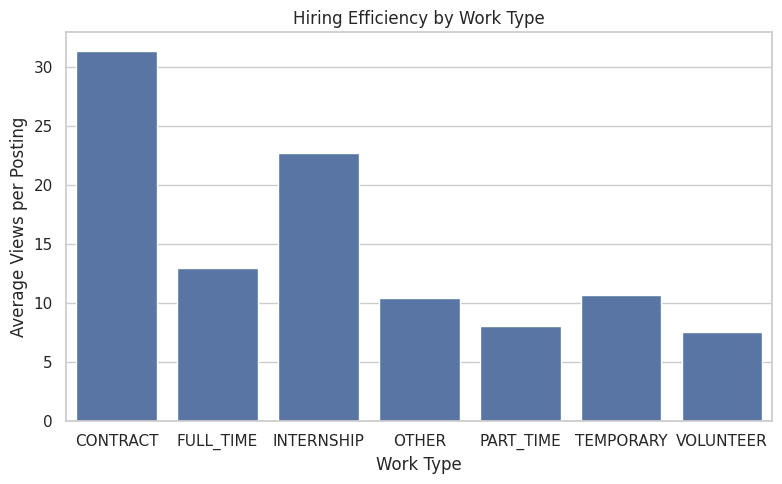

,work_type,postings,total_views,hiring_efficiency_work_type
0,CONTRACT,12117,"380,119.00",31.37
1,FULL_TIME,98814,"1,283,044.00",12.98
2,INTERNSHIP,983,"22,330.00",22.72
3,OTHER,487,"5,064.00",10.40
4,PART_TIME,9696,"78,302.00",8.08
5,TEMPORARY,1190,"12,678.00",10.65
6,VOLUNTEER,562,"4,228.00",7.52


In [15]:
# 4.4 Hiring Efficiency by Work Type (On-site vs Remote vs Hybrid)

wt_col = "work_type"

work_stats = (
    df.groupby(wt_col)
      .agg(
          postings=("job_id", "count"),
          total_views=("hiring_efficiency", "sum")
      )
      .reset_index()
)

work_stats["hiring_efficiency_work_type"] = work_stats["total_views"] / work_stats["postings"]

plt.figure(figsize=(8, 5))
sns.barplot(data=work_stats,
            x=wt_col,
            y="hiring_efficiency_work_type")
plt.title("Hiring Efficiency by Work Type")
plt.xlabel("Work Type")
plt.ylabel("Average Views per Posting")
plt.tight_layout()
plt.show()

work_stats


### Findings

*   **Contract Roles Lead**: 'CONTRACT' roles demonstrate significantly higher average views per posting, indicating strong demand or specialized targeting for these positions.
*   **Internships are Efficient**: 'INTERNSHIP' roles also show high efficiency, suggesting a substantial candidate pool for temporary or entry-level opportunities.
*   **Full-Time Moderate**: While 'FULL_TIME' roles constitute the vast majority of postings, their average views per posting are moderate, falling below contract and internship types.
*   **Lower Efficiency for Part-Time/Volunteer**: 'PART_TIME' and 'VOLUNTEER' positions tend to have the lowest hiring efficiency, receiving fewer views on average.






- Recruiters:
  - Can unlock higher candidate interest by offering more flexible work options.
- LinkedIn:
  - Can highlight remote/hybrid roles more strongly to candidates interested in flexibility.
  - Recommend flexibility as a lever for low-performing postings.


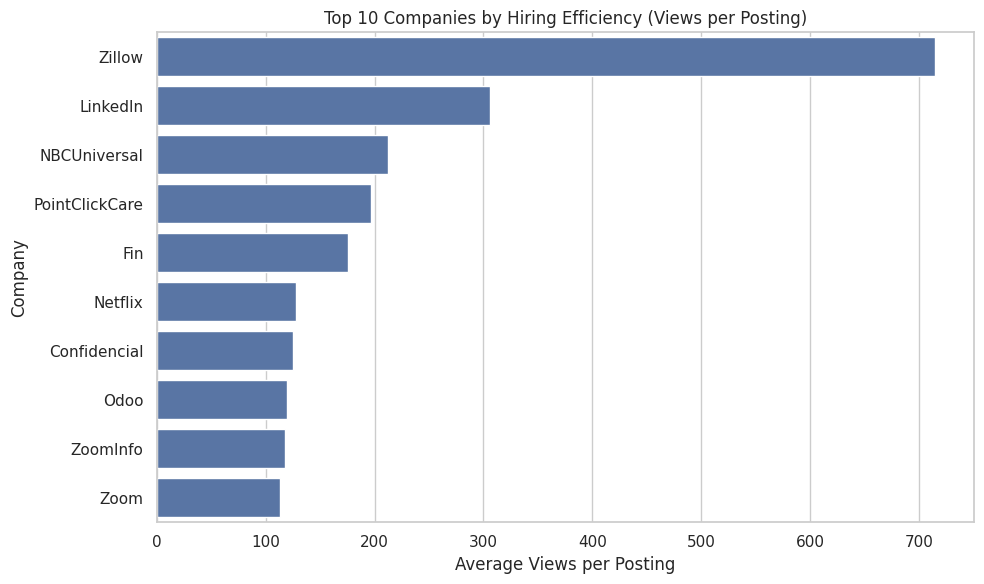

,company_name,postings,total_views,hiring_efficiency_company
24050,Zillow,17,"12,149.00",714.65
12526,LinkedIn,19,"5,817.00",306.16
14209,NBCUniversal,73,"15,489.00",212.18
16490,PointClickCare,43,"8,474.00",197.07
7848,Fin,15,"2,630.00",175.33
14536,Netflix,10,"1,277.00",127.70
5199,Confidencial,17,"2,121.00",124.76
15182,Odoo,14,"1,672.00",119.43
24081,ZoomInfo,10,"1,182.00",118.20
24078,Zoom,12,"1,362.00",113.50


In [16]:
# 4.5 Hiring Efficiency by Company (Top 10 Companies with Most Postings)

comp_col = "company_name"

company_stats = (
    df.groupby(comp_col)
      .agg(
          postings=("job_id", "count"),
          total_views=("hiring_efficiency", "sum")
      )
      .reset_index()
)

company_stats["hiring_efficiency_company"] = (
    company_stats["total_views"] / company_stats["postings"]
)

company_stats_filtered = company_stats[company_stats["postings"] >= 10]

top_companies = (
    company_stats_filtered
    .sort_values("hiring_efficiency_company", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_companies,
            x="hiring_efficiency_company",
            y=comp_col)
plt.title("Top 10 Companies by Hiring Efficiency (Views per Posting)")
plt.xlabel("Average Views per Posting")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

top_companies


### Findings
*   **Tech Dominance**: Companies like Zillow, LinkedIn, and Netflix show exceptionally high hiring efficiency, often indicating strong brand appeal.
*   **Brand Impact**: Well-known companies attract significantly more views per posting, highlighting the impact of employer brand.

### Recommendations
*   **For Recruiters**: Leverage company branding and optimize job descriptions based on successful postings from high-efficiency companies.
*   **For LinkedIn**: Highlight success stories and offer tools to boost visibility for all companies, especially smaller or less-known ones.

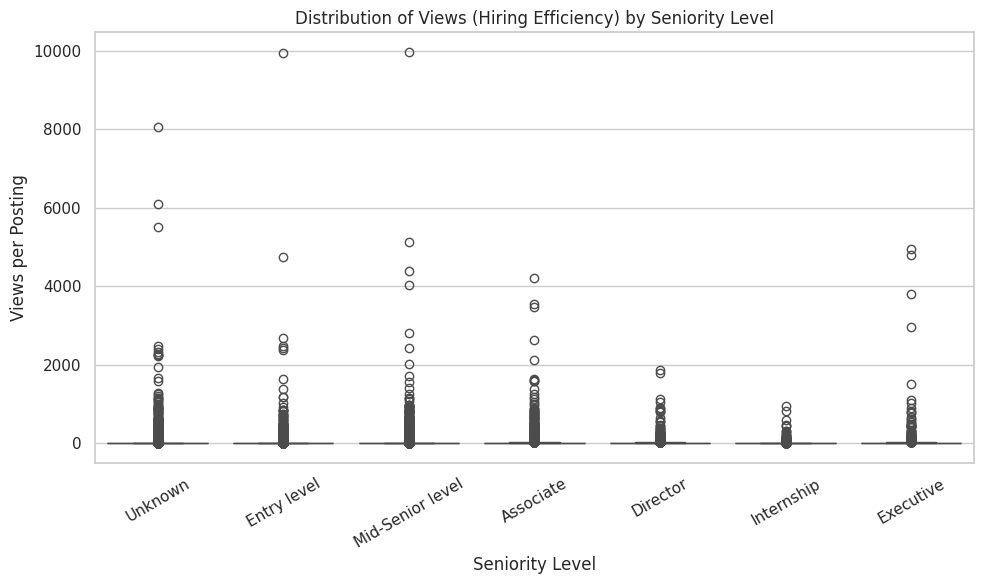

In [17]:
# 4.6 Distribution of Hiring Efficiency by Seniority Level

sen_col = "formatted_experience_level"

if sen_col in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=sen_col, y="hiring_efficiency")
    plt.title("Distribution of Views (Hiring Efficiency) by Seniority Level")
    plt.xlabel("Seniority Level")
    plt.ylabel("Views per Posting")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    print("Seniority column not available.")


### Findings
*   **Mid-Seniority Attracts More Views**: Roles at Manager, Mid-Senior, and Director levels generally receive higher average views, suggesting strong candidate interest in career progression.
*   **Entry-Level and Executive Nuances**: Entry-level roles have a broader range of views, while executive roles, though fewer, can command significant attention due to their specialized nature.
*   **'Unknown' Needs Clarification**: The 'Unknown' category is too broad to provide specific insights and may obscure important trends.

### Recommendations
*   **For Recruiters**: Tailor outreach for mid-senior roles given their higher visibility, and consider enhanced marketing for entry-level roles.
*   **For LinkedIn**: Implement better classification for 'Unknown' experience levels to improve data quality and enable more granular analysis.

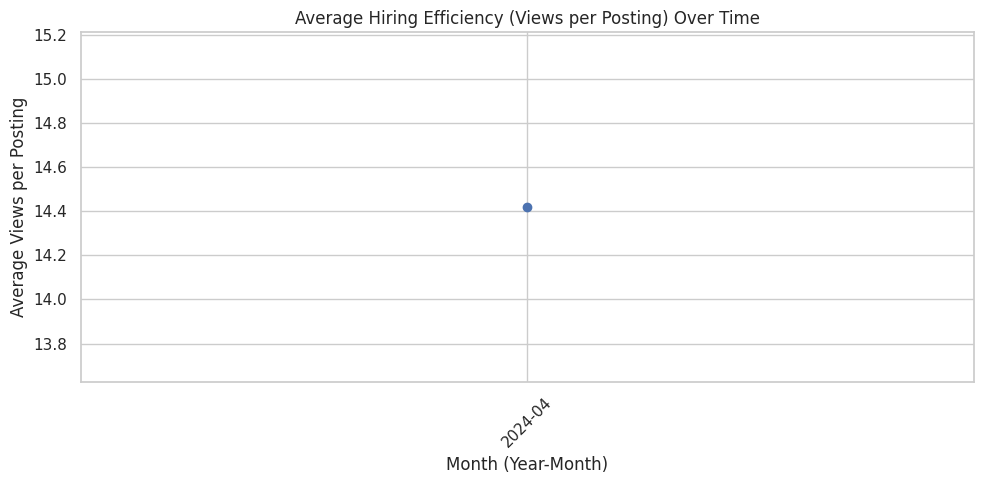

In [18]:
# 4.7 Time Trend: Average Hiring Efficiency by Month

if "listed_month" in df.columns:
    time_stats = (
        df.groupby("listed_month")
          .agg(
              avg_views=("hiring_efficiency", "mean"),
              postings=("job_id", "count")
          )
          .reset_index()
    )

    # Sort chronologically
    time_stats = time_stats.sort_values("listed_month")

    # ✅ Filter out low-volume months (noise threshold)
    time_stats_filtered = time_stats[time_stats["postings"] >= 100]

    plt.figure(figsize=(10, 5))
    plt.plot(time_stats_filtered["listed_month"],
             time_stats_filtered["avg_views"],
             marker="o")

    plt.title("Average Hiring Efficiency (Views per Posting) Over Time")
    plt.xlabel("Month (Year-Month)")
    plt.ylabel("Average Views per Posting")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    time_stats_filtered
else:
    print("listed_month not available.")



In [19]:
time_stats.head()


,listed_month,avg_views,postings
0,2024-03,3.00,1
1,2024-04,14.42,123848


## Summary:


The reason only two months appear in `time_stats` is that the `listed_month` column, derived from `listed_time`, contains data exclusively for two months: March 2024 and April 2024.

### Data Analysis Key Findings
*   The `listed_time` column was successfully converted to a datetime object, confirmed by its `datetime64[ns]` data type.
*   The date range for the `listed_time` column spans from `2024-03-24 21:50:14` (minimum) to `2024-04-20 00:26:56` (maximum).
*   An analysis of the `listed_month` value counts reveals a highly skewed distribution across only two months:
    *   `2024-04` accounts for the vast majority of entries, with 123,848 job postings.
    *   `2024-03` contains only 1 job posting.

### Insights or Next Steps
*   The dataset predominantly covers activity from April 2024, with minimal historical data from March 2024. This narrow time window should be considered for any time-series analysis or trend identification.


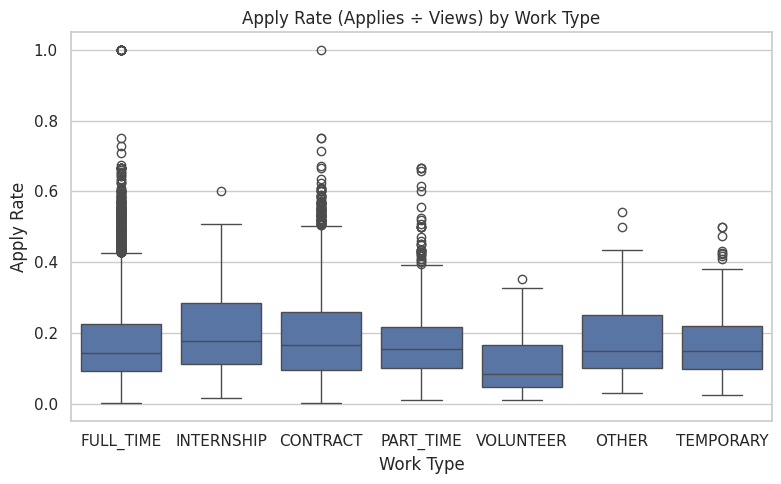

In [20]:
# 4.8 Apply Rate by Work Type (Conversion Subset Only)

if not conv_df.empty:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=conv_df, x="work_type", y="apply_rate")
    plt.title("Apply Rate (Applies ÷ Views) by Work Type")
    plt.xlabel("Work Type")
    plt.ylabel("Apply Rate")
    plt.tight_layout()
    plt.show()
else:
    print("Conversion subset empty; cannot compute apply_rate by work_type.")


### Findings
*   **High Conversion Work Types**: Some work types show higher apply rates, meaning views translate more effectively into applications (e.g., possibly specific Contract or Full-time roles).
*   **Variability in Engagement**: There's considerable variation in apply rates across different work types, indicating that candidate interest post-viewing differs significantly.

### Recommendations
*   **Recruiters**: Identify work types with high apply rates to learn conversion best practices for job description clarity and applicant targeting.
*   **LinkedIn**: Develop features or guidelines to assist recruiters in improving apply rates for work types that currently show lower conversion.

In [21]:
# EXPORT FOR TABLEAU DASHBOARD

from google.colab import files

tableau_cols = [
    "job_id",
    "title",
    "location",
    "views",
    "hiring_efficiency",
    "company_name",
    "company_id",
    "work_type",
    "formatted_work_type",
    "application_type",
    "formatted_experience_level",
    "listed_time",
    "listed_year",
    "listed_month"
]

# keep only columns that exist
tableau_cols = [c for c in tableau_cols if c in df.columns]

tableau_df = df[tableau_cols].copy()

# export
tableau_file = "NL_LinkedIn_Tableau.csv"
tableau_df.to_csv(tableau_file, index=False)

print("✅ Tableau dataset exported as:", tableau_file)
print("✅ Rows:", tableau_df.shape[0])
print("✅ Columns:", tableau_df.shape[1])

# ✅ trigger download popup
files.download(tableau_file)


✅ Tableau dataset exported as: NL_LinkedIn_Tableau.csv
✅ Rows: 123849
✅ Columns: 14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Key Findings and Recommendations

### Findings
*   **Job Titles**: Specific titles like 'Customer Operations - Talent Community' and 'Customer Success Associate' demonstrate exceptionally high average views per posting, indicating strong candidate interest in these specific roles or fields.
*   **Work Type Efficiency**: 'CONTRACT' and 'INTERNSHIP' roles show significantly higher average views per posting, suggesting a strong demand for flexible or entry-level opportunities. Conversion rates (applies/views) also vary by work type.
*   **Company Brand Impact**: Well-known companies, particularly in the tech sector (e.g., Zillow, LinkedIn, Netflix), exhibit exceptionally high hiring efficiency, underlining the significant role of employer brand in attracting visibility.
*   **Seniority Level Views**: Mid-seniority roles (Manager, Mid-Senior, Director) generally attract more views, suggesting a robust candidate pool interested in career progression.

### Recommendations
*   **For Recruiters (Job Postings)**: Optimize job descriptions and targeting strategies by analyzing successful postings from high-performing job titles and work types. Leverage company branding effectively.
*   **For Recruiters (Work Type)**: Consider offering more flexible work options (e.g., contract, remote, hybrid) where appropriate, as they tend to attract higher candidate interest and potentially better conversion rates.
*   **For Recruiters (Seniority)**: Tailor outreach for mid-senior roles and enhance marketing efforts for entry-level positions to broaden candidate reach.
*   **For LinkedIn (Product/Algorithm)**: Develop features or provide guidelines to assist all companies in boosting visibility, especially for smaller or less-known entities. Improve classification for 'Unknown' experience levels to enable more granular analysis. Highlight successful strategies for work types with high conversion to improve overall platform efficiency.

## Key Observations and Insights

### Data Characteristics
*   **Missing Data**: Salary-related fields and the `applies` count have substantial missingness (over 70%), which restricts their use in comprehensive analyses but allows for conversion rate analysis on a subset.
*   **Timeframe**: The dataset primarily covers activity from April 2024, with minimal data from March 2024, limiting the scope of historical trend analysis.
*   **Data Imputation**: Missing company identifiers and `formatted_experience_level` were imputed with 'Unknown' to maintain data integrity for categorical analysis.

### Efficiency Distribution
*   **Overall Skew**: A significant majority of job postings fall into 'Low' to 'Medium' Hiring Efficiency buckets, indicating that only a select few postings achieve exceptionally high visibility.
*   **Diverse High-Performers**: High-efficiency job titles span various sectors (e.g., customer service, administrative, operations), suggesting that high visibility is not exclusive to a single industry.
*   **Localized Hotspots**: Specific, smaller geographical locations ('Holladay, UT', 'Ambler, PA') demonstrate unusually high average views per posting, possibly due to unique regional market dynamics or specialized demand.
*   **National Reach**: The inclusion of 'United States' among high-efficiency locations indicates that remote or broadly advertised roles capture significant national attention.
*   **Seniority Range**: While mid-senior roles are strong, entry-level roles show a broader range of views, and executive roles, though fewer, can still command significant attention.
*   **Conversion Variability**: Apply rates differ considerably across various work types, implying that the effectiveness of converting views into applications is highly dependent on the type of role.

## Conclusion

The analysis successfully operationalized 'Hiring Efficiency' using job views as the primary metric and apply rate as a secondary indicator. We found significant variations in how effectively job postings attract attention across different dimensions: job titles, locations, work types, company brands, and seniority levels. These variations highlight opportunities for strategic optimization in job posting and platform design.

## Solution to Business Objective

The primary business objective was to improve **Hiring Efficiency**—how effectively a job post converts visibility into measurable interest. This analysis directly addresses this by:

1.  **Quantifying Efficiency**: Establishing `views` per posting as the core measure of Hiring Efficiency and `applies / views` as a measure of conversion for available data.
2.  **Identifying Key Drivers**: Pinpointing specific job titles, locations, work types, company brands, and seniority levels that correlate with higher (or lower) Hiring Efficiency. For example, 'CONTRACT' roles and postings by strong brands like 'Zillow' exhibit superior efficiency.
3.  **Providing Actionable Insights**: Delivering targeted recommendations for both recruiters (e.g., optimize titles, consider flexible work options, leverage branding) and LinkedIn's product teams (e.g., improve data classification, offer tools to boost visibility) that can directly lead to improved job posting performance and candidate engagement. By acting on these recommendations, the platform can enhance the relevance of job feeds, improve recruiter effectiveness, and ultimately achieve higher Hiring Efficiency.